In [12]:
import arviz as az
import folium
import pandas as pd
import numpy as np
import constants as c
import os
import matplotlib.pyplot as plt
import matplotlib
import numpyro
import numpyro.distributions as dist
import scipy
import jax.numpy as jnp
import jax

from jax import random
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide
from scipy.interpolate import BSpline

# Check to make sure Jax install isn't broken
_ = jnp.ones((3,))
jax.devices()

matplotlib.style.use('dark_background')



# Loading data

In [14]:
df = pd.read_parquet(os.path.join(c.DATA_DIR, 'brvehins', 'brvehins_clean.parquet'))
df['log_exposure'] = np.log10(df['ExposTotal'])

n_cities = df['city_idx'].max() + 1

# Our other factors are VehCategory and VehBrand; these will be used as categorical variables
# to index into random effects for each category and brand
n_categories = df['VehCategory'].cat.codes.max() + 1
n_brands = df['VehBrand'].cat.codes.max() + 1

city_filepath = os.path.join(c.DATA_DIR, 'brvehins', 'br_city_lat_long.parquet')
city_df       = pd.read_parquet(city_filepath)


graph_filepath = os.path.join(c.DATA_DIR, 'brvehins', 'city_graph.npz')
geo_graph = scipy.sparse.load_npz(graph_filepath) 

assert df['city_idx'].max() == geo_graph.shape[0] - 1

# Running model

In [17]:
inference_method = 'svi'

In [57]:
def model(geo_idx, brand_idx, category_idx, log_exposure, claim_nb_coll, times, geo_adj_matrix=None, k=None, spline_exposure=True, n_spline_knots=10, spline_degree=3):

    # Hyperparameters for the geo random effect
    sigma_geo = numpyro.sample('sigma_geo', dist.HalfNormal(1))

    # Random effect for each geo
    # If we have adjacency matrix, use conditional autogression
    # Otherwise, use independent Gaussian
    n_geos = np.max(geo_idx) + 1

    if geo_adj_matrix is None:
        print('Using independent Gaussian for per-geo unit random effect')
        with numpyro.plate('geo', n_geos):
            geo_effect = numpyro.sample('geo_effect', dist.Normal(0., sigma_geo))
    
    else:
       # Spatial autocorrelation parameter which needs to reside in (0,1)
        rho = numpyro.sample('rho', dist.Beta(2, 2))
        car_precision = sigma_geo**-2
        geo_effect = numpyro.sample('geo_effect', dist.CAR(0., rho, car_precision, geo_adj_matrix, is_sparse=True))

    sigma_brand = numpyro.sample('sigma_brand', dist.HalfNormal(1))

    # random effect for each brand
    with numpyro.plate('brand', n_brands):
        brand_effect = numpyro.sample('brand_effect', dist.Normal(0., sigma_brand))

    sigma_category = numpyro.sample('sigma_category', dist.HalfNormal(1))

    # random effect for each category
    with numpyro.plate('category', n_categories):
        category_effect = numpyro.sample('category_effect', dist.Normal(0., sigma_category))

    # Gaussian random walk effect for time
    n_timesteps = len(np.unique(times))
    sigma_grw   = numpyro.sample('sigma_grw', dist.HalfNormal(1))
    grw = numpyro.sample('grw', dist.GaussianRandomWalk(scale=sigma_grw, num_steps=n_timesteps))

    # Create represent category x brand interaction
    # matrix as output of low-rank matrix factorization
    # with k factors
    if k is not None:
        # Hyperparameters for the low-rank factorization
        sigma_latent_category = numpyro.sample('sigma_latent_category', dist.HalfNormal(1))

        # Low-rank factorization of the interaction matrix with k factors
        latent_category = numpyro.sample('latent_category', dist.Normal(jnp.zeros([n_categories, k]), sigma_latent_category*jnp.ones([n_categories, k])))
        latent_geo = numpyro.sample('latent_brand', dist.Normal(jnp.zeros([n_brands, k]), jnp.ones([n_brands, k]))) # Scale is fixed so that we don'y have identifiability issues
        interaction_effect = numpyro.deterministic('interaction_effect', (latent_category @ latent_geo.T))
        interaction_term = interaction_effect[category_idx, brand_idx]

    else:
        interaction_term = 0.

    # Allow for a spline-based adjustment to the log exposure to indicate if the exposure-risk relationship
    # is not quite linear. The basic idea is that we want to use priors to encourage the spline to be equal to the zero function
    # and add it to the log exposure. We can then use the spline coefficients as a measure of how much the exposure-risk relationship
    # deviates from linearity.
    if spline_exposure:
        
        spline_input = log_exposure

        # We'll place the knots at equidistant percentiles of the exposure, from the min val up to the max val with the nunber
        # of knots specified by n_knots 
        expos_quantiles = np.quantile(log_exposure, np.linspace(0, 1, n_spline_knots))

        # This is to make sure all of the input domain is covered by the piecewise functions
        padded_knots = np.hstack([[spline_input.min()] * (spline_degree + 1), expos_quantiles, [spline_input.max()] * (spline_degree + 1)])

        # Get the spline basis matrix
        get_basis = lambda x: BSpline(padded_knots, np.eye(len(padded_knots) - spline_degree - 1), spline_degree)(x)[:, 1:]

        spline_basis   = get_basis(spline_input)
        n_spline_coefs = spline_basis.shape[1]

        spline_scale = numpyro.sample('spline_scale', dist.HalfNormal(1))
        spline_coefs = numpyro.sample('spline_coefs', dist.Normal(jnp.zeros(n_spline_coefs), spline_scale*jnp.ones(n_spline_coefs) ))
        spline_term  = jnp.dot(spline_basis, spline_coefs)

        # Evaluate the spline on grid of points for reference
        spline_grid       = np.quantile(log_exposure, np.linspace(0, 1, 100))
        spline_grid_basis = get_basis(spline_grid)
        spline_grid_eval  = numpyro.deterministic("spline", jnp.dot(spline_grid_basis, spline_coefs))

    else:
        spline_term = 0.

    
    # Model for the log-mean
    log_mean = log_exposure +  \
        geo_effect[geo_idx] + brand_effect[brand_idx] + category_effect[category_idx] \
        + grw[times] + interaction_term + spline_term

    mu = jnp.exp(log_mean)

    # Poisson likelihood
    with numpyro.plate('data', len(geo_idx)):
        numpyro.sample('obs', dist.Poisson(mu), obs=claim_nb_coll)

rng_key = random.PRNGKey(0)


if inference_method == "svi":
    # Run SVI
    guide = autoguide.AutoDiagonalNormal(model)

    iters = 100_000
    optimizer = numpyro.optim.Adam(0.001)
    svi = SVI(model, guide, optimizer, Trace_ELBO())
    svi_results = svi.run(random.PRNGKey(1), iters, geo_idx=df['city_idx'].values,
                brand_idx=df['VehBrand'].cat.codes.values,
                category_idx=df['VehCategory'].cat.codes.values,
                log_exposure=df['log_exposure'].values,
                claim_nb_coll=df['ClaimNbColl'].values,
                times=df['VehYearSince1971'].values,
                geo_adj_matrix=geo_graph,
                k=10)
    
    params = svi_results.params
    trace = guide.sample_posterior(rng_key, params, sample_shape = (100,))

elif inference_method == "mcmc":

    # Run NUTS
    rng_key, rng_key_ = random.split(rng_key)
    nuts_kernel = NUTS(model)

    mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=1, thinning=10)

    # Clocks at 12s/it at 1024 steps on CPU, so ~10 ms per stepb
    mcmc.run(rng_key_, 
                geo_idx=df['city_idx'].values,
                brand_idx=df['VehBrand'].cat.codes.values,
                category_idx=df['VehCategory'].cat.codes.values,
                log_exposure=df['log_exposure'].values,
                claim_nb_coll=df['ClaimNbColl'].values,
                times=df['VehYearSince1971'].values,
                geo_adj_matrix=geo_graph,
                k=10)

    samples = mcmc.get_samples()
    trace = {k: v[0] for k, v in samples.posterior.items()}

else:
    raise ValueError(f"Unknown inference method {inference_method}")

100%|██████████| 100000/100000 [10:00<00:00, 166.44it/s, init loss: 1223526318080.0000, avg. loss [95001-100000]: 705291.0000]


# Examining results

In [50]:
trace.keys()

dict_keys(['brand_effect', 'category_effect', 'geo_effect', 'grw', 'interaction_effect', 'latent_category', 'latent_geo', 'log_offset', 'rho', 'sigma_brand', 'sigma_category', 'sigma_geo', 'sigma_grw', 'sigma_latent_category', 'spline', 'spline_coefs', 'spline_scale'])

## Plots

### Spline plot

(-3.0, 4.0)

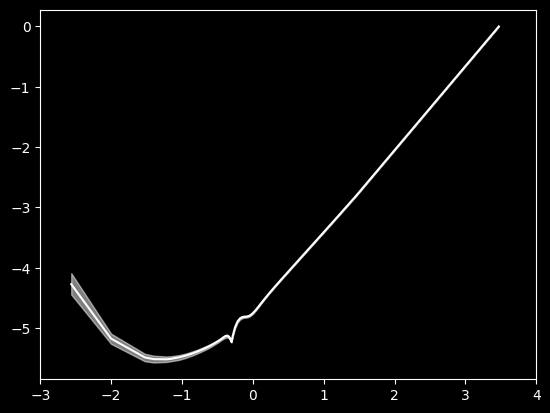

In [51]:
# Plot the median / 5% / 95% quantiles of the spline
qs = np.quantile(trace['spline'], [0.05, 0.5, 0.95], axis=0)

xs = np.quantile(df['log_exposure'], np.linspace(0, 1, 100))
plt.plot(xs, qs[1], color='white')
plt.fill_between(xs, qs[0], qs[2], color='white', alpha=0.5)

plt.xlim([-3, 4])

## Plot of per-brand and per-category effects

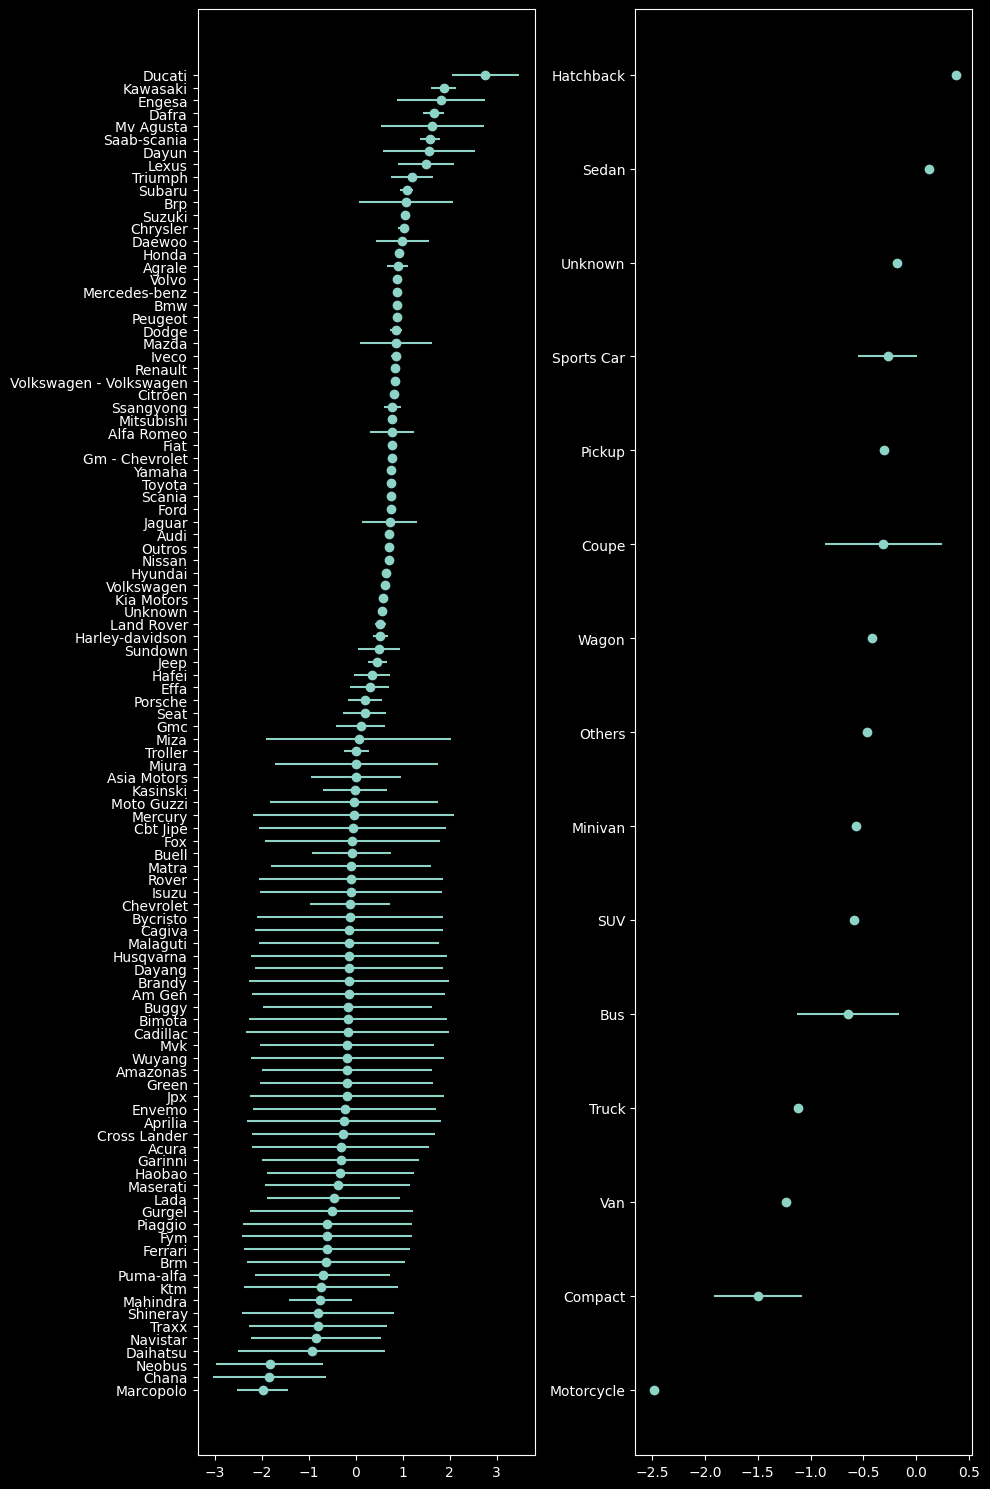

In [52]:
fig, axes = plt.subplots(1,2, figsize=(10, 15))
axes = axes.flatten()

brand_effect = trace['brand_effect'].mean(axis=0)
brand_effect_std = trace['brand_effect'].std(axis=0)

# Sort the brands by the estimated effect and plot 2 sigma error bars
brand_df = pd.DataFrame({'brand': df['VehBrand'].cat.categories, 'effect': brand_effect, 'effect_std': brand_effect_std})
brand_df = brand_df.sort_values('effect')

axes[0].errorbar(brand_df['effect'], brand_df['brand'], xerr=2*brand_df['effect_std'], fmt='o')

# Add second subplot for the category plot
category_effect = trace['category_effect'].mean(axis=0)
category_effect_std = trace['category_effect'].std(axis=0)

category_df = pd.DataFrame({'category': df['VehCategory'].cat.categories, 'effect': category_effect, 'effect_std': category_effect_std})
category_df = category_df.sort_values('effect')

axes[1].errorbar(category_df['effect'], category_df['category'], xerr=2*category_df['effect_std'], fmt='o')


plt.tight_layout()

<Axes: >

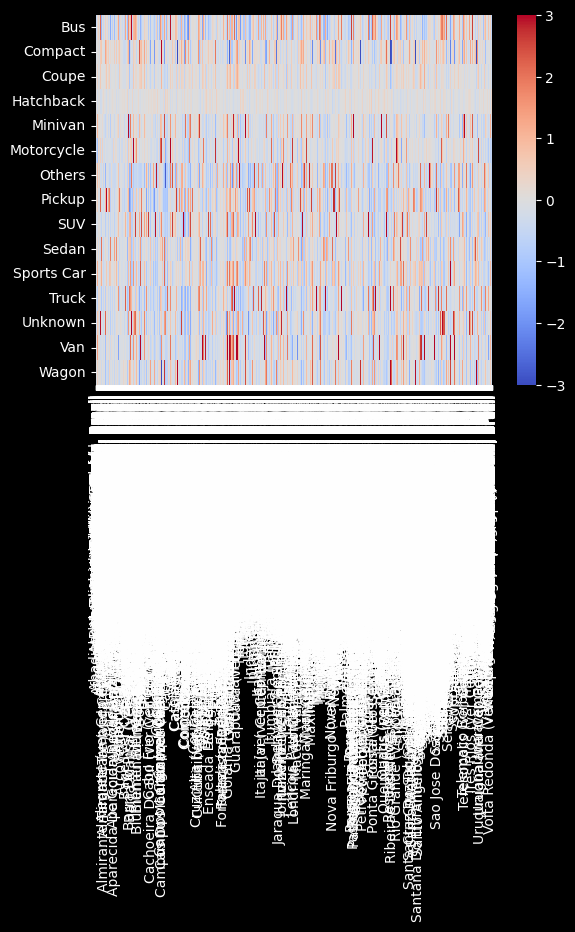

In [62]:
import seaborn as sns

sns.heatmap(trace['interaction_effect'].mean(axis=0),
            xticklabels=city_df['city-state'].values,
            yticklabels=df['VehCategory'].cat.categories,
            cmap='coolwarm',
            center=0,
            vmin=-3,
            vmax=3)

### Map of spatial random effect

In [53]:
geo_effect     = trace['geo_effect'].mean(axis=0)
geo_effect_std = trace['geo_effect'].std(axis=0)

# Create a Folium map using the locations of the cities
# and the size of the geo effects to make markers
# on the map. The marker color is controlled by the effect size.
m = folium.Map(location=[-15.77972, -47.92972], zoom_start=6)

# Get colors for the markers
norm = plt.Normalize(geo_effect.min(), geo_effect.max())
cmap = plt.cm.get_cmap('coolwarm')
geo_effect_colors = cmap(norm(geo_effect))

# Map colors to hex codes
geo_effect_colors = [matplotlib.colors.rgb2hex(cmap(norm(v))) for v in geo_effect]

for i, row in city_df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=4,
        popup=row['city-state'],
        color=geo_effect_colors[i],
        fill=True,
        fill_color=geo_effect_colors[i],
    ).add_to(m)

m

/tmp/ipykernel_3617546/1585522606.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


Text(0.5, 0, 'Vehicle year')

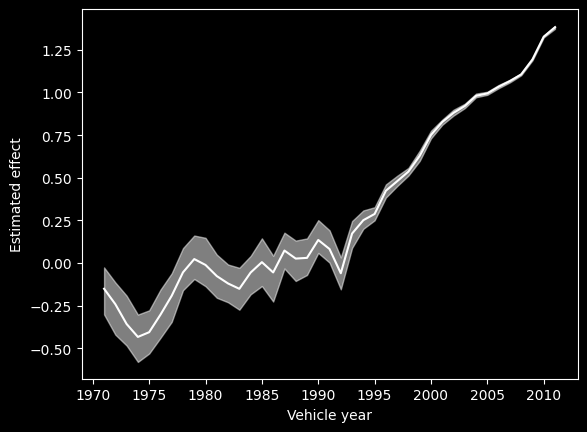

In [56]:

# Plot the median / 5% / 95% quantiles of the spline
qs = np.quantile(trace['grw'], [0.05, 0.5, 0.95], axis=0)
xs = np.arange(1971, 2012)

plt.plot(xs, qs[1], color='white')
plt.fill_between(xs, qs[0], qs[2], color='white', alpha=0.5)
plt.ylabel("Estimated effect")
plt.xlabel("Vehicle year")